# Activity Recognition

This project aims to develop a machine learning model which can be used to predict the type of activity performed by an individual based on data collected by wearable sensors. This classification task will be accomplished using a combination of supervised and unsupervised machine learning methods. This project is a proof-of-concept meant to demonstrate the effectiveness of machine learning models at accomplishing this task and how they may differ.

The ability to predict the activity an individual is performaing based on data from a wearable device can be trememndously impactful. It can provide value to the company producing the wearable as a new product feature, as seen in many smart watches, cell phones and other wearables. It can also provide value to an individual by revealing habits and behaviors and enouraging healthy levels of activity and timely rest.

The data used in this project is sourced from the Daily and Sports Activities dataset from the UC Irving Machine Learning Repository (UCI Machine Learning Repository. (2018). Uci.edu. https://archive.ics.uci.edu/dataset/256/daily+and+sports+activities). It contains 9,120 instances and 5,625 features. Each instance represents one of 19 activities performed by an individual for 5 minutes, and each feature represents values recorded by 45 sensors on the individual which took 125 recordings during the activity.

The following activities are included in the dataset:
* sitting
* standing
* lying on back
* lying on right side
* ascending stairs
* descending stairs
* standing in elevator
* moving in elevator
* walking in parking lot
* walking on flat treadmill
* walking on incline treadmill
* running on treadmill
* exercising on stepper
* exercising on cross trainer
* horizontal cycling
* vertical cycling
* rowing
* jumping
* playing basketball

However, due to the complexity of identifying the best label permutation for the unsupervised learning models, which has a time complexity of n factorial, we will only use a subset of 8 of the activities.


## Loading Data

We'll begin by importing libraries and loading and cleaning the data. The data is nested within the `./data` directory (e.g. `./data/a05/p5/s14.txt`), so we'll use `os.walk()` to navigate the directory structure and read the data.

To clean the data, we will create a new feature for the activity type, which we will use as the target variable. We will also convert the sensor value data types to numeric. Finally, we will filter the dataset to include only a subset of all activities. This will allow us to calculate the best label permutation for the unsupervised learning models. If we include all 19 activites, we would have to evaluate all 19 permutations, which scales in time complexity by a factor of n factorial, which we do not have time for!

In [1]:
# Importing libraries
import os
from itertools import permutations

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_mutual_info_score, roc_curve, auc
from sklearn.pipeline import Pipeline

In [2]:
# Loading data
# walk through the data directory and read the txt files
data_dict = {}
for root, dirs, files in os.walk("data"):
    for file in files:
        if file.endswith(".txt"):
            with open(os.path.join(root, file), "r") as f:
                # replace new line with comma and split by comma
                text = f.read().replace("\n", ",").split(",")
                # remove empty strings
                text = [i for i in text if i]
                # store the data in a dictionary with the file path as the key
                data_dict[os.path.join(root, file)] = text

# convert the data to a pandas dataframe
df = pd.DataFrame.from_dict(data_dict, orient='index').reset_index()
df.columns = ['file_name'] + ['sensor_value_' + str(i) for i in range(1, len(df.columns))]

# inspect the data
print(df.shape)
print(df.head())

(9120, 5626)
             file_name sensor_value_1 sensor_value_2 sensor_value_3  \
0  data/a05/p4/s06.txt         8.4679        -2.7189        0.94689   
1  data/a05/p4/s12.txt         8.1374        -3.2649         0.9865   
2  data/a05/p4/s13.txt         8.4187        -2.9418       -0.71775   
3  data/a05/p4/s07.txt         7.8393         -2.696         2.0539   
4  data/a05/p4/s39.txt         9.5991        -2.5011         2.4535   

  sensor_value_4 sensor_value_5 sensor_value_6 sensor_value_7 sensor_value_8  \
0        0.63928      -0.040385       0.067077       -0.36969         0.5546   
1        0.77633       0.089779        0.15779       -0.43743        0.77384   
2        0.56766        -0.3223        0.23219       -0.40913        0.75279   
3        0.34867       0.042874       -0.11061       -0.28866        0.48226   
4        0.11115       -0.24018       0.091841       -0.22087        0.54586   

  sensor_value_9  ... sensor_value_5616 sensor_value_5617 sensor_value_5618  \


In [3]:
# Cleaning the data
# create columns for each activity, person and session based on the file name
df['activity'] = df['file_name'].apply(lambda x: x.split('/')[1])
df['person'] = df['file_name'].apply(lambda x: x.split('/')[2])
df['session'] = df['file_name'].apply(lambda x: x.split('/')[3].split('.')[0])

# convert columns which start with "sensor_value_" to numeric
# we will also use this list of columns in our analysis and modeling
sensor_value_columns = [item for item in df.columns if item.startswith('sensor_value_')]
df[sensor_value_columns] = df[sensor_value_columns].apply(pd.to_numeric)

# update activity values to be more readable
# print(df['activity_key'].unique())
activity_type_dict = {
    'a01': 'sitting',
    'a02': 'standing',
    'a03': 'lying on back',
    'a04': 'lying on right side',
    'a05': 'ascending stairs',
    'a06': 'descending stairs',
    'a07': 'standing in elevator',
    'a08': 'moving in elevator',
    'a09': 'walking in parking lot',
    'a10': 'walking on flat treadmill',
    'a11': 'walking on incline treadmill',
    'a12': 'running on treadmill',
    'a13': 'exercising on stepper',
    'a14': 'exercising on cross trainer',
    'a15': 'horizontal cycling',
    'a16': 'vertical cycling',
    'a17': 'rowing',
    'a18': 'jumping',
    'a19': 'playing basketball'
}

df['activity'] = df['activity'].map(activity_type_dict)

# remove activities to reduce complexity
activities_to_keep = [
    'sitting',
    'standing',
    'lying on back',
    'ascending stairs',
    'walking on flat treadmill',
    'running on treadmill',
    'horizontal cycling',
    'playing basketball'
]

df = df[df['activity'].isin(activities_to_keep)]

# update person values
df['person'] = df['person'].apply(lambda x: x.replace('p', 'person_'))

# update session values
df['person'] = df['person'].apply(lambda x: x.replace('s', 'session_'))

# store unique activities and create a mapping
activities = df['activity'].unique()
n_activities = len(activities)
activity_mapping = {activity: i for i, activity in enumerate(activities)}
df['activity_key'] = df['activity'].map(activity_mapping)

/var/folders/hj/ldmxw7n16190zgh_c6m4mxgm0000gq/T/ipykernel_92189/2254045292.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['activity_key'] = df['activity'].map(activity_mapping)


## Exploratory Data Analysis

Now that the data has been loaded and cleaned, we can begin our exploratory data analysis (EDA). The goal of this analysis is to reveal insights about the structure and patterns in the data to improve our understanding of it and to inform transformations, pre-processing and modeling.

Since the dimensionality of this data is very high and the features are all values recorded from the same sensors, we will plot histograms of the means, mins, and maxs of each of the features to give us a sense of how each feature is distributed.

From there, we will use principal component analysis (PCA), a dimensionality reduction technique, to vizualize the data and see whether any distinct clusters can be detected. 

Text(0.5, 1.0, 'Histogram of mean sensor values')

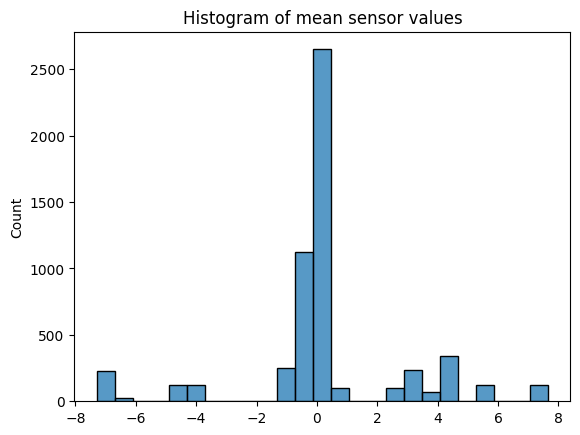

In [ ]:
# Histogram of mean sensor values
means = df[sensor_value_columns].mean()
sns.histplot(means, bins=25)
plt.title('Histogram of mean sensor values')

Text(0.5, 1.0, 'Histogram of max sensor values')

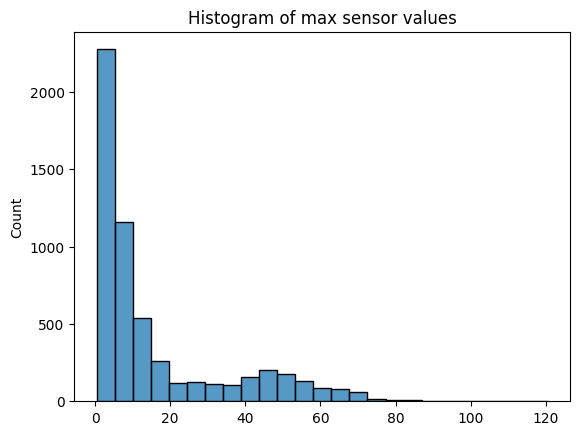

In [5]:
# Histogram of max sensor values
maxs = df[sensor_value_columns].max()
sns.histplot(maxs, bins=25)
plt.title('Histogram of max sensor values')

Text(0.5, 1.0, 'Histogram of min sensor values')

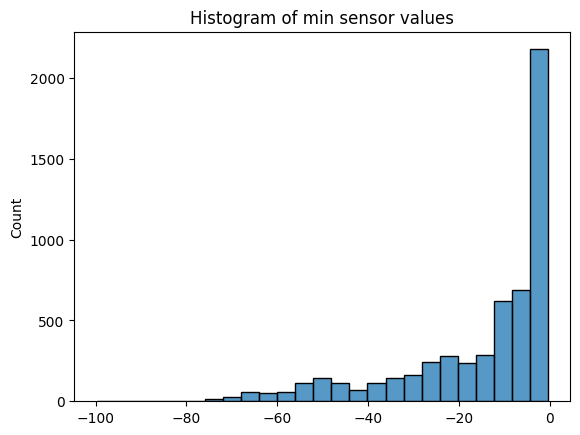

In [ ]:
# Histogram of min sensor values
mins = df[sensor_value_columns].min()
sns.histplot(mins, bins=25)
plt.title('Histogram of min sensor values')

Variance explained by PCA components: 0.3062


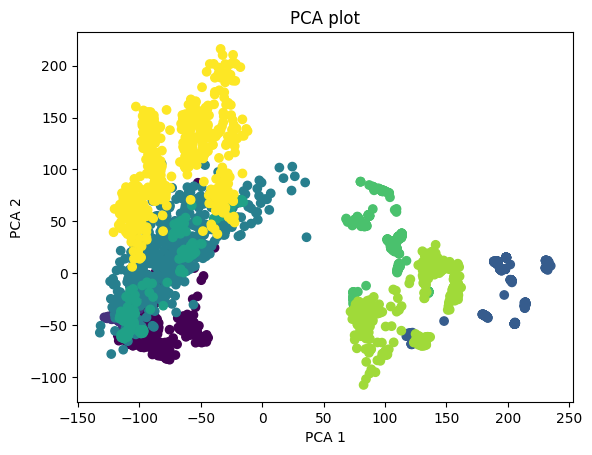

In [7]:
# PCA dimensionality reduction to visualize the data
# standardize the data
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df[sensor_value_columns])

# fit PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[sensor_value_columns])

# how well does PCA explain the variance in the data?
print("Variance explained by PCA components: {}".format(round(pca.explained_variance_ratio_.sum(), 4)))

# plot the PCA - color by activity
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=pd.factorize(df['activity'])[0])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA plot')
# plt.legend(activities)
plt.show()

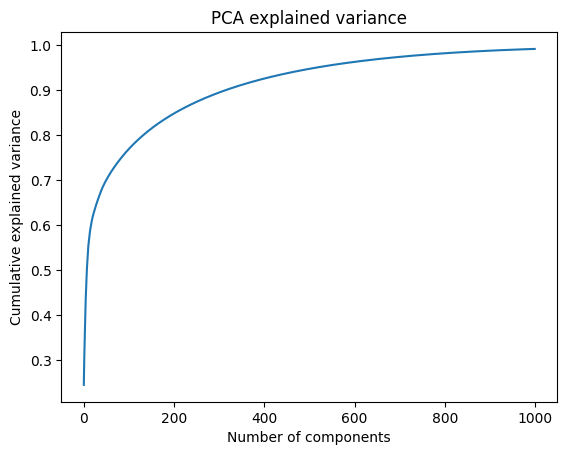

In [8]:
# Cumulative explained variance
pca = PCA(n_components=1000)
df_pca = pca.fit_transform(df[sensor_value_columns])
pca_vars = pca.explained_variance_ratio_.cumsum()
plt.plot(pca_vars)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA explained variance')
plt.show()

After inspecting the histograms, we can notice a few patterns. First, there appears to be distinct groups of means. These groups could be different activity types, but they could also be different sensor positions or orientations. We also notice that the range of values is quite large, from about -100 to 120. We may need to scale our data to improve the performance of certain models.

The PCA data visualization also reveals some interesting insights. It appears to reveal distinct clusters of data for each activity type. This is very encouraging to see! However, some activity clusters appear less dense than others, and some are split into mutliple clusters. Also, the total variance explained by the first two principal components is only 0.3062, so it does not a complete representation of the dataset.

The last plot shows the cumulative explained variance by each principal component. We can use this to select the number of principal components to use during dimensionality reduction while developing our models.

## Data Modeling

We'll begin data modeling by pre-processing the data. We'll define the number of principal components to test during dimensionality reduction, and we will scale the data to improve the performance of distance-based models. We will also define a function used to find the best label permutation for the unsupervized learning models. Finally, we'll split the data into train and test datasets.

The models we will train and tune include two unsupervized learning models, k-means clustering and hierarchical clustering, and one supervized learning model, logistic regression. We will then evaluate the models and compare the results.

For evaluation, we will inspect the accuracy, adjusted mututal information (AMI) and confusion matrix of each model. The AMI metric is used to measure how well an clustering algorithm categories data, agnostic of the values of each label. This allows us to evaluate the performance without having to iterate over every label permutation to calculate accuracy.

In [11]:
# Pre-processing
# save principal components which explain 50%, 70%, 90%, 95% of the variance
var_thresholds = [0.5, 0.7, 0.9, 0.95]
npc_thresholds = [sum(pca_vars < threshold) for threshold in var_thresholds]
print('Explained Variance: {}\nPrincipal components: {}'.format(var_thresholds, npc_thresholds))
npc_thresholds = npc_thresholds + [None]

# scaling the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[sensor_value_columns])

# funtion to find the best label permutation
def find_best_permutation(y_true, y_pred):
    n_categories = len(set(y_true))
    best_perm = None
    best_acc = 0
    for perm in permutations(range(n_categories)):
        perm = list(perm)
        acc = accuracy_score(y_true, [perm[label] for label in y_pred])
        if acc > best_acc:
            best_acc = acc
            best_perm = perm
    return best_perm, best_acc

# train and test split
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df['activity_key'], test_size=0.2, random_state=42)

Explained Variance: [0.5, 0.7, 0.9, 0.95]
Principal components: [7, 50, 315, 516]


### K-Means Clustering

The first method we will use is k-means clustering. Since this is a distance-based algorithm which could be impacted by the curse of dimensionality, we will use PCA to reduce the dimensions, iterating over the number principal components identified above. We will also set the number of clusters to the number of activities since that is known.

In [ ]:
# K-means clustering training
# hyperparameter tuning
param_grid = {
    'pca__n_components': npc_thresholds,
    # 'pca__n_components': [None],
}

# loop through params and calculate training accruacy
best_acc = 0
best_perm = None
best_params = None
for n_components in param_grid['pca__n_components']:
    # create pipeline
    pipeline = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('kmeans', KMeans(n_clusters=n_activities, random_state=42))
    ])
    # if n components is None, remove PCA step
    if n_components is None:
        pipeline.set_params(pca = 'passthrough')
    pipeline.fit(X_train)
    y_pred = pipeline.predict(X_train)
    perm, acc = find_best_permutation(y_train, y_pred)
    print('PCA components: {}, Accuracy: {}'.format(n_components, acc))
    if acc > best_acc:
        best_acc = acc
        best_perm = perm
        best_params = {'pca__n_components': n_components}

print(best_acc, best_params)

PCA components: 7, Accuracy: 0.5517578125
PCA components: 50, Accuracy: 0.4798177083333333
PCA components: 315, Accuracy: 0.4954427083333333
PCA components: 516, Accuracy: 0.5524088541666666
PCA components: None, Accuracy: 0.619140625
0.619140625 {'pca__n_components': None}


Adjusted Mutual Information: 0.6678667335864489
Accuracy: 0.6614583333333334


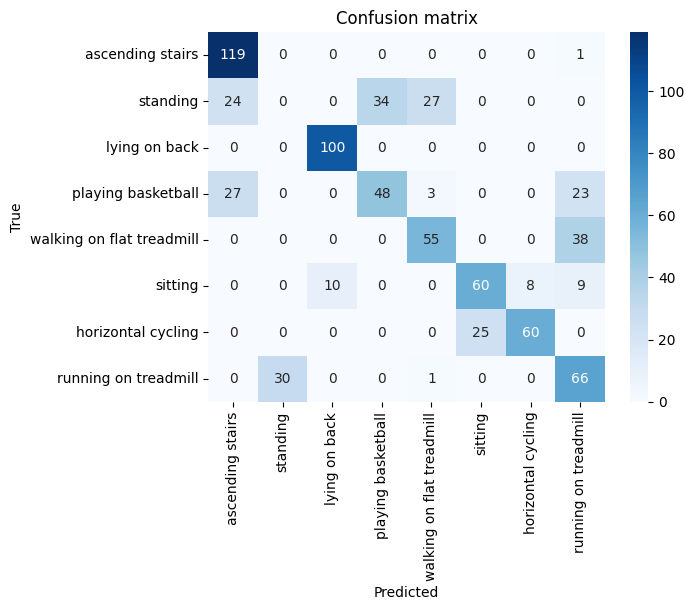

In [ ]:
# K-means clustering evaluation
kmeans_pipeline = Pipeline([
    ('pca', PCA(n_components=best_params['pca__n_components'])),
    ('kmeans', KMeans(n_clusters=n_activities, random_state=42))
])
if best_params['pca__n_components'] is None:
    kmeans_pipeline.set_params(pca='passthrough')

# fit on training data, predict test data
kmeans_pipeline.fit(X_train)
y_pred = kmeans_pipeline.predict(X_test)

# adjusted mutual information
ami = adjusted_mutual_info_score(y_test, y_pred)
print('Adjusted Mutual Information: {}'.format(ami))

# accuracy
perm, acc = find_best_permutation(y_test, y_pred)
print('Accuracy: {}'.format(acc))

# confusion matrix
cm = confusion_matrix(y_test, [perm[label] for label in y_pred])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

The best k-means clustering algorithm acheived an accuracy of 66.146% and an AMI of 0.668. Interestingy, the best model did not include any dimensionality reduction, despite k-means being a distance-based algorithm.

After inspecting the confusion matrix, it appears the model most often misclassifies "walking on a treadmill" as "running on a treadmill", "standing" as "playing basketball", and "running on a treadmill" as "standing"

### Hierarchical Clustering

The next model we will train and tune is a hierarchical clustering model. For this model, we will again iterate over several different principal components and set the number of clusters equal to the number of activities we are attemping to predict. We will also iterate over different metrics and linkage types in the clustering step.

In [ ]:
# Hierarchical clustering training
# hyperparameter tuning
param_grid = {
    # only include a few components to reduce complexity
    'pca__n_components': [7, 315, None], # components which explain 50%, 90%, 100% of the variance
    'agg__metric': ['euclidean', 'cosine'], # also checked 'manhattan' but it didn't improve the accuracy
    'agg_linkage': ['ward', 'complete'], # also checked 'average' but it didn't improve the accuracy
}

# loop through params and calculate training accruacy
best_acc = 0
best_perm = None
best_params = None
for n_components in param_grid['pca__n_components']:
    for metric in param_grid['agg__metric']:
        for linkage in param_grid['agg_linkage']:
            # ward linkage only works with euclidean metric'
            if linkage == 'ward' and metric != 'euclidean':
                continue
            # create pipeline
            pipeline = Pipeline([
                ('pca', PCA(n_components=n_components)),
                ('agg', AgglomerativeClustering(
                    n_clusters=n_activities,
                    metric=metric,
                    linkage=linkage
                ))
            ])
            # if n components is None, remove PCA step
            if n_components is None:
                pipeline.set_params(pca = 'passthrough')
            y_pred = pipeline.fit_predict(X_train)
            perm, acc = find_best_permutation(y_train, y_pred)
            print('PCA components: {}, Metric: {}, Linkage: {}, Accuracy: {}'.format(n_components, metric, linkage, acc))
            if acc > best_acc:
                best_acc = acc
                best_perm = perm
                best_params = {
                    'pca__n_components': n_components,
                    'agg__metric': metric,
                    'agg_linkage': linkage
                }

print(best_acc, best_params)

PCA components: 7, Metric: euclidean, Linkage: ward, Accuracy: 0.5660807291666666
PCA components: 7, Metric: euclidean, Linkage: complete, Accuracy: 0.3981119791666667
PCA components: 7, Metric: cosine, Linkage: complete, Accuracy: 0.5963541666666666
PCA components: 315, Metric: euclidean, Linkage: ward, Accuracy: 0.5550130208333334
PCA components: 315, Metric: euclidean, Linkage: complete, Accuracy: 0.13834635416666666
PCA components: 315, Metric: cosine, Linkage: complete, Accuracy: 0.6461588541666666
PCA components: None, Metric: euclidean, Linkage: ward, Accuracy: 0.5465494791666666
PCA components: None, Metric: euclidean, Linkage: complete, Accuracy: 0.2532552083333333
PCA components: None, Metric: cosine, Linkage: complete, Accuracy: 0.5966796875
0.6461588541666666 {'pca__n_components': 315, 'agg__metric': 'cosine', 'agg_linkage': 'complete'}


Adjusted Mutual Information: 0.653576044355611
Accuracy: 0.6302083333333334


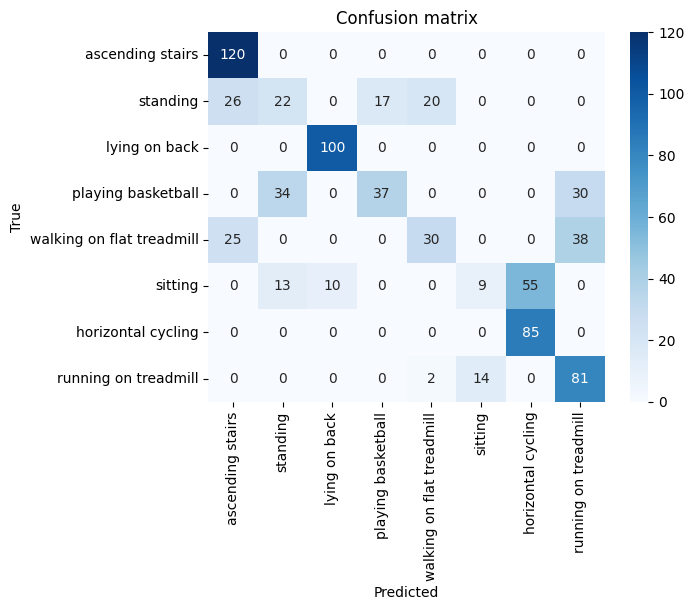

In [15]:
# Hierarchical clustering evaluation
agg_pipeline = Pipeline([
    ('pca', PCA(n_components=best_params['pca__n_components'])),
    ('agg', AgglomerativeClustering(
        n_clusters=n_activities,
        metric=best_params['agg__metric'],
        linkage=best_params['agg_linkage']
    ))
])

# fit and predict test data
y_pred = agg_pipeline.fit_predict(X_test)

# adjusted mutual information
ami = adjusted_mutual_info_score(y_test, y_pred)
print('Adjusted Mutual Information: {}'.format(ami))

# accuracy
perm, acc = find_best_permutation(y_test, y_pred)
print('Accuracy: {}'.format(acc))

# confusion matrix
cm = confusion_matrix(y_test, [perm[label] for label in y_pred])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

The best hierarchical clustering model achieves and accuracy of 63.021% and an AMI of 0.654. It uses 315 principal components, the 'cosine' metric, and a 'complete' linkage.

After inspecting the confusion matrix, it appears the model often misclassifies "sitting" as "horizontal cycling", "walking on a treadmill" as "running on a treadmill", and "playing basketball" as "standing"

### Logistic Regression

The final model we will train is a logistic regression classification model. Similar to the previous models, we will search for the optimal dimensionionality. We will also iterate over a couple of penalty types for the logistic regression classifier.

In [ ]:
# Logistic regression training
# hyperparameter tuning
param_grid = {
    # only include a few components to reduce complexity
    'pca__n_components': [7, 315, None], # components which explain 50%, 90%, 100% of the variance
    'lr__penalty': ['l2', 'l1'],
}

# use grid search to find the best hyperparameters
pipeline = Pipeline([
    ('pca', PCA()),
    ('lr', LogisticRegression(solver='liblinear', multi_class='auto'))
])

grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

/Users/kevin.katzmann/.pyenv/versions/data_science/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kevin.katzmann/.pyenv/versions/data_science/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/kevin.katzmann/.pyenv/versions/data_science/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9801445936283468
{'lr__penalty': 'l1', 'pca__n_components': 315}
Pipeline(steps=[('pca', PCA(n_components=315)),
                ('lr', LogisticRegression(penalty='l1', solver='liblinear'))])


Adjusted Mutual Information: 0.9767514012319906
Accuracy: 0.9895833333333334


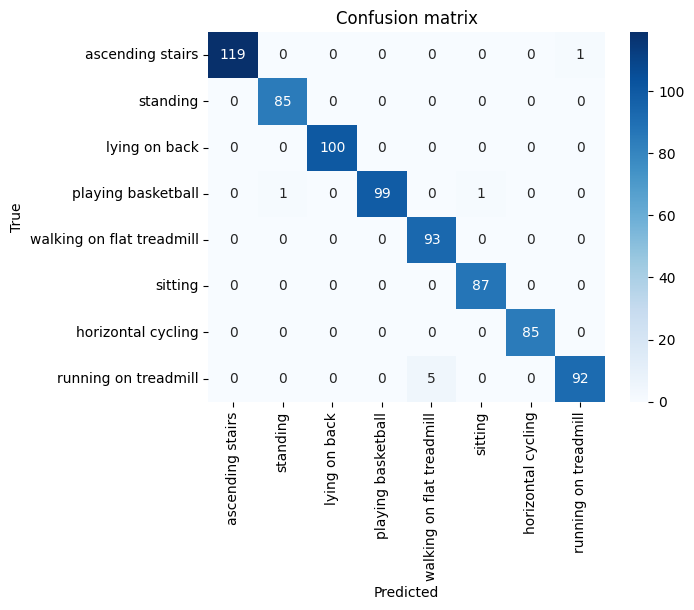

In [24]:
# Logistic regression evaluation
lr_pipeline = grid.best_estimator_

# predict test data
y_pred = lr_pipeline.predict(X_test)

# adjusted mutual information
ami = adjusted_mutual_info_score(y_test, y_pred)
print('Adjusted Mutual Information: {}'.format(ami))

# accuracy
acc = accuracy_score(y_test, y_pred)
print('Accuracy: {}'.format(acc))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

The best logistic regression model achieved an accuracy of 98.958% and an AMI of 0.977. This substantially outperforms the two unsupervised algorithms we trained! The best model uses 315 principal components and an 'l1' penalty.

## Results

We have successfully demonstrated that a machine learning model can be trained to predict the type of activity performed by an individual! Our logistic regression model was able to predict the type of activity performed by an individual with an accuracy of 98.958%

The logistic regression model substantially outperformed the two unsupervised learning algorithms. This is not exactly surprosing though; logistic regression is designed for classification tasks such as this one. The unsupervized learning algorithms are more suited for clustering tasks.

Despite ther poor performance, the two unsupervised learning algorithms still revealed some interesting insights. By comparing their confusion matrices, we see that there are a couple of common misclassifications. For instance, "walking on a treadmill" was often misclassified as "running on a treadmill" by both algorithms. By inspecting these misclassifications further, we can begin to understand which activities are most similar and either classify them together in a future iteration or spend more time teasing them apart.

There is still much work to be done here. Future work could include using clustering algorithms to identify subgroups within each activity and using clustering algorithms to identify similar ones. It might also include training a few additional classification models and optimizing for performance. And finally, it the remaining activities should be included as well so that final model can produce complete predictions of all activities.